In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pylab import rcParams
# from sklearn.model_selection import GridSearchCV, train_test_split


warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(15, 7)})
sns.set_style('white')
pd.set_option('display.max_columns', 500)

###### Time Series Analysis

In [275]:
housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')

df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()

In [3]:
# train = df.iloc[:48]
# test = df.iloc[48:]

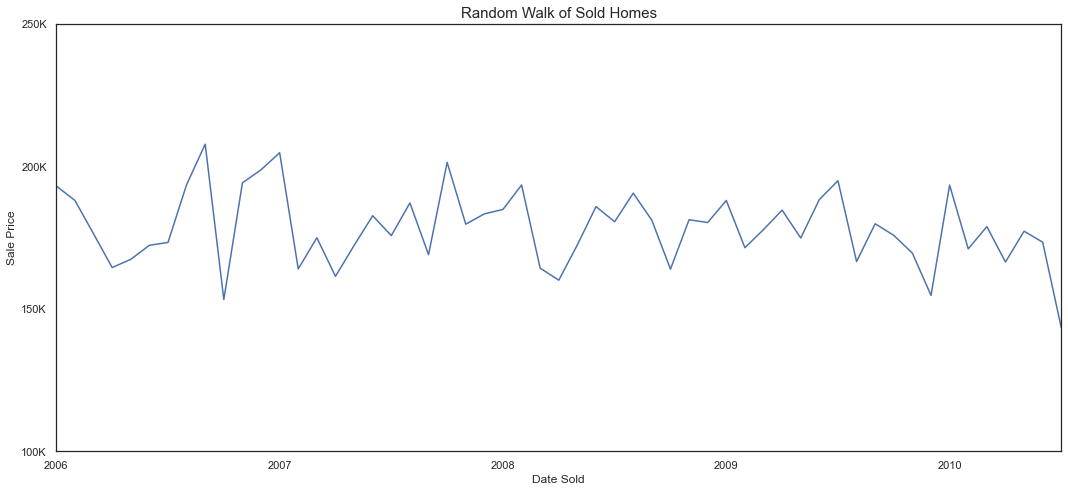

In [28]:
fig = df.plot(legend=False)
fig.set(xlabel='Date Sold',
        ylabel='Sale Price',
        xticks=['2006-01', '2007-01', '2008-01', '2009-01', '2010-01'],
        xticklabels=list(range(2006, 2011)),
        yticks=[1e5, 1.5e5, 2e5, 2.5e5],
        yticklabels=['100K', '150K', '200K', '250K'])
plt.title('Random Walk of Sold Homes', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Timeseries DateSold, Lineplot.png', dpi = 1000)
plt.show()

In [175]:
adf = sm.tsa.adfuller(df, regression='ct')
print(f'adf test: {adf[0]}, p-value: {adf[1]}')

# looks like we can reject the null hypothesis and continue with the test

adf test: -7.862907943240698, p-value: 1.4823410516174927e-10


In [247]:
neighborhood = 'SWISU'

housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
housing = housing[housing['Neighborhood'] == neighborhood]
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')
df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
print(f'len: {len(df)}')

len: 26


In [236]:
len(df)/2

0.5

In [243]:
# for i in neighborhoods:
#     neighborhood = i

#     housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
#     housing = housing[housing['Neighborhood'] == neighborhood]
#     DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
#                             housing['MoSold'].astype(str) + '-1').rename('DateSold')
#     df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
#     print(f'{i} len: {len(df)}')
    
#     try:
#         rcParams['figure.figsize'] = 18, 8
#         decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=int(len(df)/2))
#         fig = decomposition.plot()
#         plt.show()
#     except:
#         pass

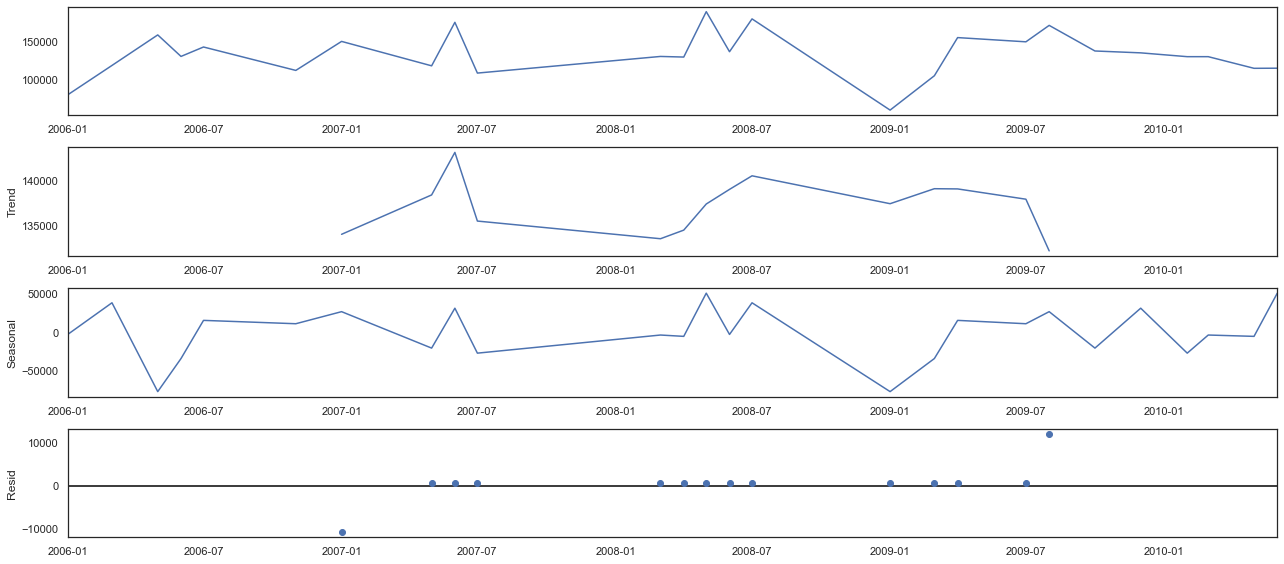

In [233]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=13)
fig = decomposition.plot()
plt.show()

# there's a clear trend downwards -- this is probably due to the housing crisis
# we can also clearly see a seasonality trend
# residuals all look normalized, for the most part

In [244]:
# lets find the best parameters with the lowest AIC score and lowest MSE

optimal_sarima = 1e6
pdq = []
seasonal_pdq = []

for arima, sarima, aic in results:
    if aic < optimal_sarima:
        optimal_sarima = aic
        pdq = arima
        seasonal_pdq = sarima
    else:
        continue
        
print(f'arima: {pdq}, sarima: {seasonal_pdq}, AIC: {optimal_sarima}')

arima: (1, 1, 1), sarima: (1, 1, 1, 11), AIC: 10.0


In [245]:
results

[[(0, 0, 0), (0, 0, 0, 11), 1461.2175637434527],
 [(0, 0, 0), (0, 0, 1, 11), 1134.8815527826287],
 [(0, 0, 0), (0, 1, 0, 11), 948.358951451852],
 [(0, 0, 0), (0, 1, 1, 11), 989.7489615509239],
 [(0, 0, 0), (1, 0, 0, 11), 969.7167746878723],
 [(0, 0, 0), (1, 0, 1, 11), 950.1052599445668],
 [(0, 0, 0), (1, 1, 0, 11), 732.063663706013],
 [(0, 0, 0), (1, 1, 1, 11), 1134.5351507820199],
 [(0, 0, 1), (0, 0, 0, 11), 1398.94107388695],
 [(0, 0, 1), (0, 0, 1, 11), 1172.4780124532906],
 [(0, 0, 1), (0, 1, 0, 11), 927.939997920171],
 [(0, 0, 1), (0, 1, 1, 11), 688.6247435390446],
 [(0, 0, 1), (1, 0, 0, 11), 1151.0102541874485],
 [(0, 0, 1), (1, 0, 1, 11), 1100.9611257357187],
 [(0, 0, 1), (1, 1, 0, 11), 734.0934805006307],
 [(0, 0, 1), (1, 1, 1, 11), 1133.1462453928805],
 [(0, 1, 0), (0, 0, 0, 11), 1191.118882903548],
 [(0, 1, 0), (0, 0, 1, 11), 933.6381635713747],
 [(0, 1, 0), (0, 1, 0, 11), 955.6125294299012],
 [(0, 1, 0), (0, 1, 1, 11), 1303.608695713855],
 [(0, 1, 0), (1, 0, 0, 11), 957.09532

In [246]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
result = mod.fit(disp=False)
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ar.S.L12            0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.000       1.000       1.000


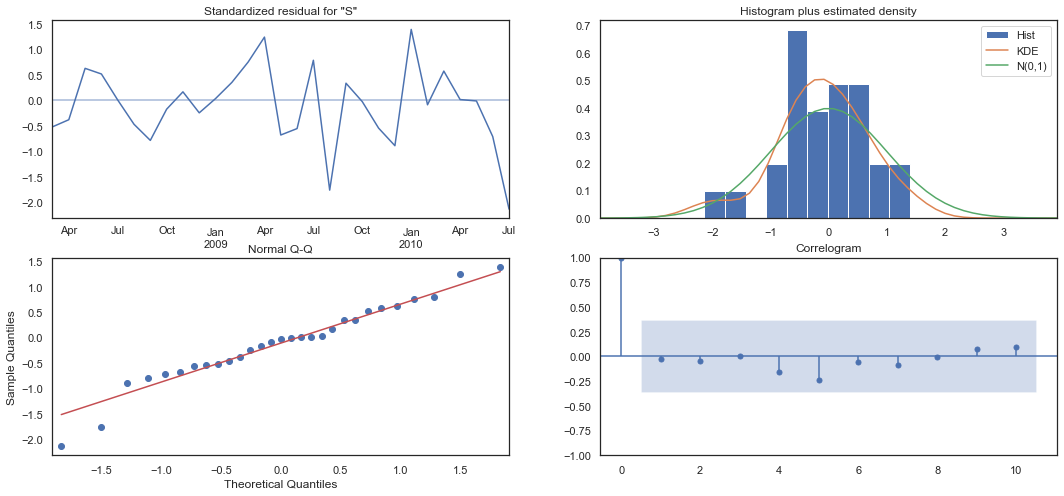

In [226]:
result.plot_diagnostics()
plt.show()

In [273]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
result = mod.fit(disp=False)
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5048        nan        nan        nan         nan         nan
ma.L1         -0.1002        nan        nan        nan         nan         nan
ar.S.L12      -0.5786        nan        nan        nan         nan         nan
sigma2      2.246e+09        nan        nan        nan         nan         nan


In [198]:
result = mod.fit(disp=False, return_params=True)

In [172]:
neighborhood = 'OldTown'

housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
housing = housing[housing['Neighborhood'] == neighborhood]
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')

df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
print(f'len: {len(df)}')

len: 48


In [162]:
housing['Neighborhood'].unique()

array(['SWISU', 'Edwards', 'IDOTRR', 'OldTown', 'NWAmes', 'Blmngtn',
       'Mitchel', 'NridgHt', 'NAmes', 'CollgCr', 'SawyerW', 'MeadowV',
       'BrDale', 'Gilbert', 'Timber', 'Somerst', 'BrkSide', 'NoRidge',
       'Sawyer', 'Crawfor', 'Greens', 'ClearCr', 'GrnHill', 'StoneBr',
       'Veenker', 'NPkVill', 'Blueste', 'Landmrk'], dtype=object)

In [303]:
result.get_prediction(start=pd.to_datetime('2009-09-01'), dynamic=True).predicted_mean.append(result.get_forecast(steps=10).predicted_mean)

2009-09-01    183611.270200
2009-10-01    164975.245948
2009-11-01    174832.334021
2009-12-01    155679.721200
2010-01-01    203688.499802
2010-02-01    174898.357619
2010-03-01    171150.667883
2010-04-01    158045.726017
2010-05-01    165174.105696
2010-06-01    172006.500760
2010-07-01    174230.644299
2010-08-01    177608.348875
2010-09-01    140181.707326
2010-10-01    149459.741904
2010-11-01    133992.400399
2010-12-01    133751.181083
2011-01-01    176668.582307
2011-02-01    145737.390691
2011-03-01    156292.949800
2011-04-01    149735.360283
2011-05-01    147042.532157
Freq: MS, Name: predicted_mean, dtype: float64

In [304]:
pred_ci.ap

,lower SalePrice,upper SalePrice
2010-08-01,121702.299837,233514.397914
2010-09-01,73603.323669,206760.090984
2010-10-01,76045.988578,222873.495229
2010-11-01,58426.912043,209557.888754
2010-12-01,56137.140539,211365.221628
2011-01-01,98636.379758,254700.784857
2011-02-01,66982.213442,224492.567941
2011-03-01,77495.699623,235090.199977
2011-04-01,70635.784014,228834.936551
2011-05-01,67956.167391,226128.896924


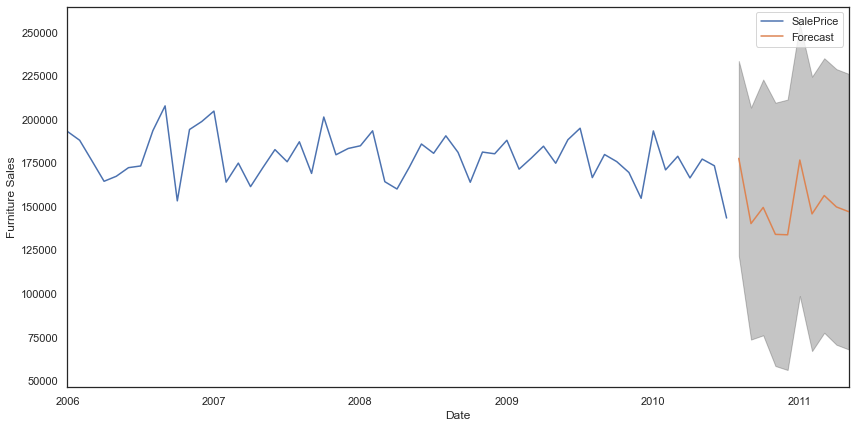

In [298]:
pred_uc = result.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

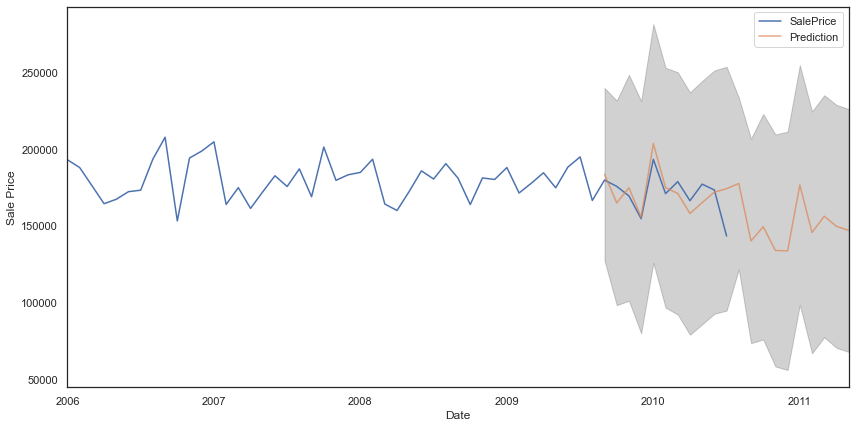

arima: (1, 1, 1), sarima: (1, 2, 1, 12), aic: 370.90910113060954, rmse = 13882.42137457328


In [305]:
pdq = (1, 1, 1)
PDQM = (1, 2, 1, 12)

mod = sm.tsa.statespace.SARIMAX(df,
                                order=pdq,
                                seasonal_order=PDQM,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
result = mod.fit(disp=False)

predict = result.get_prediction(start=pd.to_datetime('2009-09-01'), dynamic=True)
forecast = result.get_forecast(steps=10)

ci = predict.conf_int().append(forecast.conf_int())
pred = predict.predicted_mean.append(forecast.predicted_mean)

ax = df.plot(label='Observed')
pred.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 7))
mse = ((df['2010-01-01':].squeeze() - pred) ** 2).mean()
ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
plt.show()
print(f'arima: {pdq}, sarima: {PDQM}, aic: {result.aic}, rmse = {mse ** 0.5}')

In [98]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)

result = mod.fit(disp=False)
result.

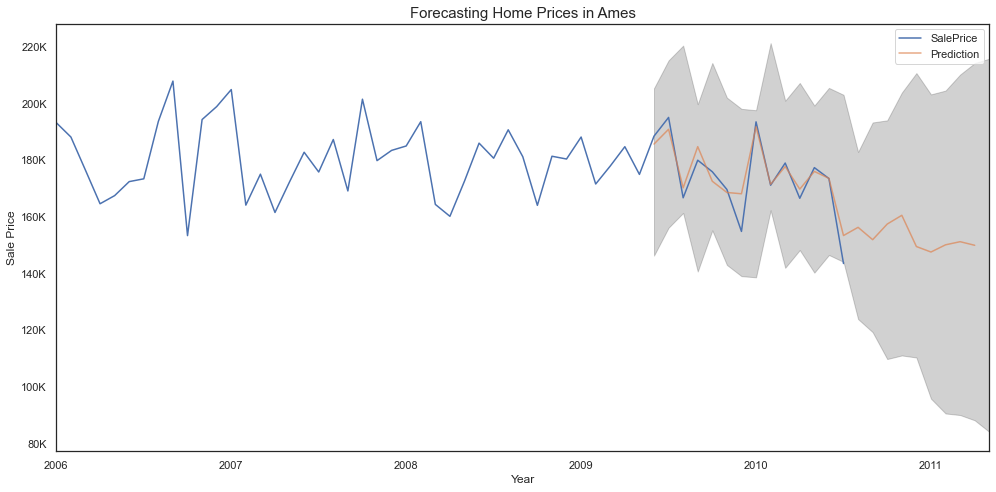

In [330]:
pdq = (1, 1, 1)
PDQM = (1, 0, 1, 12)

mod = sm.tsa.statespace.SARIMAX(df,
                                order=pdq,
                                seasonal_order=PDQM,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
result = mod.fit(disp=False)


# predict = result.get_prediction(start=pd.to_datetime('2009-09-01'), dynamic=True)
# forecast = result.get_forecast(steps=10)

# ci = predict.conf_int().append(forecast.conf_int())
# pred = predict.predicted_mean.append(forecast.predicted_mean)



predict = result.get_prediction(start=pd.to_datetime('2009-06-01'), dynamic=False)
forecast = result.get_forecast(steps=10)

ci = predict.conf_int().append(forecast.conf_int())
pred = predict.predicted_mean.append(forecast.predicted_mean)
ax = df.plot(label='Observed')

predicted_mean = pred.shift(-1)
predicted_mean.iloc[13] = result.forecast(1)
predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 7))

ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Sale Price')
plt.yticks([8e4, 1e5, 1.2e5, 1.4e5, 1.6e5, 1.8e5, 2e5, 2.2e5], 
           ['80K', '100K', '120K', '140K', '160K', '180K', '200K', '220K'])
plt.title('Forecasting Home Prices in Ames', fontsize = 15)
plt.legend()
plt.tight_layout()
plt.savefig('./visualizations/10step-predictions.png', dpi = 600)
plt.show()

# print(f'arima: {pdq}, sarima: {PDQM}, aic: {result.aic}, rmse = {mse ** 0.5}')

### Grid Search

In [ ]:
neighborhoods = { # [pdq], [PDQM], stationarity, invertibility, start
    'SWISU': []
}

In [195]:
neighborhoods = ['SWISU', 'Edwards', 'IDOTRR', 'OldTown', 'NWAmes', 'Blmngtn',
                 'Mitchel', 'NridgHt', 'NAmes', 'CollgCr', 'SawyerW', 'MeadowV',
                 'BrDale', 'Gilbert', 'Timber', 'Somerst', 'BrkSide', 'NoRidge',
                 'Sawyer', 'Crawfor', 'Greens', 'ClearCr', 'GrnHill', 'StoneBr',
                 'Veenker', 'NPkVill', 'Blueste', 'Landmrk']

In [259]:
neighborhood = 'SWISU'

housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
housing = housing[housing['Neighborhood'] == neighborhood]
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')
df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
print(f'len: {len(df)}')

len: 26


In [181]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[4]}')

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [104]:
results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            trend_offset=2)
            result = mod.fit(disp=False)
            results.append([param, param_seasonal, result.aic])
            
        except:
            continue

In [196]:
# import math

neighborhood = 'OldTown'

housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
housing = housing[housing['Neighborhood'] == neighborhood]
DateSold = pd.to_datetime(housing['YrSold'].astype(str) + '-' + 
                        housing['MoSold'].astype(str) + '-1').rename('DateSold')

df = housing[['SalePrice']].set_index(DateSold).groupby('DateSold').mean()
print(f'len: {len(df)}')


pdq = (1, 1, 1)
PDQM = (1, 0, 1, 12)

mod = sm.tsa.statespace.SARIMAX(df,
                                order=pdq,
                                seasonal_order=PDQM,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
result = mod.fit(disp=False)

pred = result.get_prediction(start=pd.to_datetime('2009-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.plot(label='Observed')

predicted_mean = pred.predicted_mean.shift(-1)
predicted_mean.iloc[13] = result.forecast(1)
predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 7))
mse = ((df['2010-01-01':].squeeze() - pred.predicted_mean) ** 2).mean()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
plt.show()
print(f'arima: {pdq}, sarima: {PDQM}, aic: {result.aic}, rmse = {mse ** 0.5}')

len: 26


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

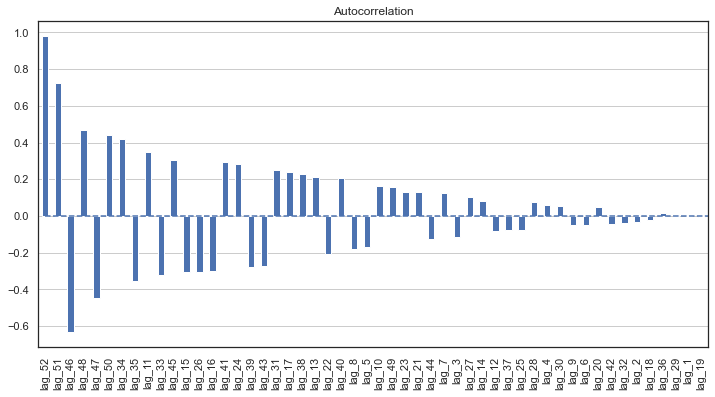

In [114]:

# auto_cor = sales.groupby("Date")["Weekly_Sales"].sum()
# auto_cor = pd.DataFrame(auto_cor)
# auto_cor.columns = ["y"]

df2 = df.copy()
# Adding the lag of the target variable from 1 steps back up to 52 (due to a seasonality at the end of the year)
for i in range(1, 53):
    df2["lag_{}".format(i)] = df2.SalePrice.shift(i)

# Compute autocorrelation of the series and its lags
lag_corr = df2.corr()
lag_corr = lag_corr.iloc[1:,0]
lag_corr.columns = ["corr"]
order = lag_corr.abs().sort_values(ascending = False)
lag_corr = lag_corr[order.index]

# Plot the Autocorrelation
plt.figure(figsize=(12, 6))
lag_corr.plot(kind='bar')
plt.grid(True, axis='y')
plt.title("Autocorrelation")
plt.hlines(y=0, xmin=0, xmax=len(lag_corr), linestyles='dashed')

In [107]:
import pmdarima as pm

In [122]:
stepwise_model = pm.auto_arima(df.iloc[:].values, start_p=1, start_q=1,
                               max_p=20, max_q=20, m=52,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=54.90 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=46.491, Time=2.17 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=35.91 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=20.54 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=5.26 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=4.21 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=46.911, Time=26.37 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=47.931, Time=1.18 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=48.884, Time=0.94 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=48.086, Time=15.16 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=46.411, Time=0.44 sec
 ARIMA(0,1,0)(1,1,0)[52] intercept   : AIC=48.145, Time=7.01 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(0,1,0)(1,1,1)[52] intercept   : AIC=49.778, Time=6.70 sec
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=49.931, Time=1.06